# EDA for COWLS2h Dataset

## Imports and Helper functions

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher, HtmlDiff
from IPython.display import HTML, display
import nltk
import hashlib

nltk.download('punkt')

BEGINNER_LEVEL_ONLY = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Helper functions
def getFormattedDiff(a, b):
    """
        Given two strings (a, b), getFormattedDiff returns the HTML formatted strings (formatted_a, formatted_b)
        Source: https://stackoverflow.com/questions/76527591/python-highlight-differences-between-two-strings-in-jupyter-notebook
    """
    # highlight colors
    color_delete = '#FBAE8A'  # Red highlight color for deletions
    color_insert = '#9FFB8A'  # Green highlight color for insertions
    color_replace = '#FBE78A' # Yellow highlight color for replacements

    # the common format string used for highlighted segments
    f_str = '<span style="background: {};">{}</span>'

    # initialize the sequence matcher
    s = SequenceMatcher(None, a, b)

    # stringbuilders for the formatted strings
    formatted_a = []
    formatted_b = []

    # iterate through all char blocks
    for tag, i1, i2, j1, j2 in s.get_opcodes():
        if tag == 'equal':
            # if the blovks are the same, append block to both strings without any formatting
            formatted_a.append(a[i1:i2])
            formatted_b.append(b[j1:j2])
        elif tag == 'delete':
            # if this is a deletion block, append block to the first string with the delete highlight
            formatted_a.append(f_str.format(color_delete, a[i1:i2]))
        elif tag == 'insert':
            # if this is a insertion block, append block to the second string with the insert highlight
            formatted_b.append(f_str.format(color_insert, b[j1:j2]))
        elif tag == 'replace':
            # if this is a replacement block, append block to both strings with the replace highlight
            formatted_a.append(f_str.format(color_replace, a[i1:i2]))
            formatted_b.append(f_str.format(color_replace, b[j1:j2]))

    # return the formatted strings
    return ''.join(formatted_a), ''.join(formatted_b)

# Display diff of two columns in dataset
def diff(df_to_diff, col1, col2, n=2, dropna=False, onlydiffs=True, colwidth=50):
    data = df_to_diff[[col1, col2]]
    if onlydiffs:
        data = data[data[col1] != data[col2]]
    if dropna:
        data = data.dropna()
    else:
        data = data.fillna('')
    samplesize = n if data.shape[0] >= n else data.shape[0]
    data = data.sample(n = samplesize)
    diff = HtmlDiff(wrapcolumn=colwidth).make_file(data[col1],data[col2], col1, col2)
    display(HTML(diff))

# dowload data
def get_data(force_download=False):
    lists = ['famous.F17.csv', 'famous.S17.csv', 'famous.S18.csv', 'famous.SU17.csv', 'famous.W18.csv',
             'vacation.F17.csv', 'vacation.S17.csv', 'vacation.S18.csv', 'vacation.SU17.csv', 'vacation.W18.csv']
    for file in lists:
        if not os.path.isfile(file):
            # File not there download it
            os.system(f'wget https://raw.githubusercontent.com/ucdaviscl/cowsl2h/master/csv/{file}')
        elif force_download:
            # Remove existing file and re-download it.
            os.remove(file)
            os.system(f'wget https://raw.githubusercontent.com/ucdaviscl/cowsl2h/master/csv/{file}')

    df = pd.concat([pd.read_csv(file) for file in lists], axis=0)
    return df

# use nltk for better spliting the sentence
def split_paragraph_with_nltk(text):
  if type(text) == str:
    combine_sentence = []
    for i in text.split('\n\n\xa0\n\n'):
      sentences = nltk.tokenize.sent_tokenize(i, language='spanish')
      combine_sentence.append(sentences)
    return [item for sublist in combine_sentence for item in sublist]
  else:
    return []

## Load Data

In [3]:
df = get_data(force_download=False)

## Initial Sanity Check

In [4]:
print(f'Number of essasys in original data: {df.shape[0]}')
print()
print(f'Columns in the original data:')
print(df.columns)
print()
print(f'Essays count at each course level:')
df['course'].value_counts()
print()
print("Sample Gender-Number annotations")
diff(df, 'essay', 'gender-number annotator2', n=3, dropna=False, colwidth=55, onlydiffs=True)

Number of essasys in original data: 1725

Columns in the original data:
Index(['Unnamed: 0', 'id', 'prompt', 'quarter', 'course', 'age', 'gender',
       'l1 language', 'other l1 language(s)', 'language(s) used at home',
       'language(s) studied', 'listening comprehension',
       'reading comprehension', 'speaking ability', 'writing ability',
       'study abroad', 'essay', 'a personal annotator1',
       'a personal annotator2', 'gender-number annotator1',
       'gender-number annotator2', 'corrected'],
      dtype='object')

Essays count at each course level:

Sample Gender-Number annotations


## Data Cleaning

### Projection and filtering of data

In [5]:
# Get rid of unneeded columns and rows
df = df[['id', 'prompt', 'quarter', 'course', 'essay', 'a personal annotator1',
   'a personal annotator2', 'gender-number annotator1',
   'gender-number annotator2']]

# add paragraph id
df['paragraph_id'] = range(1,len(df)+1)

if BEGINNER_LEVEL_ONLY:
    # Keep only beginner essays
    df = df[(df['course'] == 'SPA 1') | (df['course'] == 'SPA 2') | (df['course'] == 'SPA 3')]


<ipython-input-5-42b69671fcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['paragraph_id'] = range(1,len(df)+1)


### Clean up messy format

In [6]:
def cleanup(data):
    patterns = { '\n\xa0\n\n':'\n\n\xa0\n\n',
                '\n\n\xa0':'\n\n\xa0\n\n',
                '\n\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0':'\n\n\xa0\n\n',
                '\n\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0': '\n\n\xa0\n\n'
    }
    df_clean = data
    df_clean['essay'].replace(patterns, regex= True, inplace = True)
    df_clean['a personal annotator1'].replace(patterns, regex= True, inplace = True)
    df_clean['a personal annotator2'].replace(patterns, regex= True, inplace = True)
    df_clean['gender-number annotator1'].replace(patterns, regex= True, inplace = True)
    df_clean['gender-number annotator2'].replace(patterns, regex= True, inplace = True)
    return df_clean

df = cleanup(df)

### Drop duplicated data

In [7]:
df[df['essay'].duplicated()==True]

,id,prompt,quarter,course,essay,a personal annotator1,a personal annotator2,gender-number annotator1,gender-number annotator2,paragraph_id
41,150930,famous,S17,SPA 2,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,217


In [8]:
# drop duplicated data
df = df[(~df['essay'].duplicated())]

## Add computed cols

In [9]:
# Add error counts
def add_error_counts(data):
    pattern = r'\[.*?\]\{.*?\}\<.*?\>'

    data['p_anno1_error_cnt'] = data['a personal annotator1'].str.count(pattern)
    data['p_anno2_error_cnt'] = data['a personal annotator2'].str.count(pattern)
    data['g_anno1_error_cnt'] = data['gender-number annotator1'].str.count(pattern)
    data['g_anno2_error_cnt'] = data['gender-number annotator2'].str.count(pattern)

    data['p_anno1_error_cnt'] = data['p_anno1_error_cnt'].fillna(0)
    data['p_anno2_error_cnt'] = data['p_anno2_error_cnt'].fillna(0)
    data['g_anno1_error_cnt'] = data['g_anno1_error_cnt'].fillna(0)
    data['g_anno2_error_cnt'] = data['g_anno2_error_cnt'].fillna(0)
    data = data.astype({'p_anno1_error_cnt': int, 'p_anno2_error_cnt': int, 'g_anno1_error_cnt': int, 'g_anno2_error_cnt': int})
    return data

df = add_error_counts(df)

In [10]:
# Pick annotation with most error between the two annotated columns for both personal and gender
df['p_annotator_sel']= df.apply(lambda row: row['a personal annotator1'] if row['p_anno1_error_cnt'] >= row['p_anno2_error_cnt'] else row['a personal annotator2'], axis = 1)
df['g_annotator_sel']= df.apply(lambda row: row['gender-number annotator1'] if row['g_anno1_error_cnt'] >= row['g_anno2_error_cnt'] else row['gender-number annotator2'], axis = 1)

## Split the paragraph into sentences

In [11]:
#split into list
df['essay_new'] = df['essay'].apply(split_paragraph_with_nltk)
df['p_annotator'] = df['p_annotator_sel'].apply(split_paragraph_with_nltk)
df['g_annotator'] = df['g_annotator_sel'].apply(split_paragraph_with_nltk)

#check if the paragraph sentence count are the same
df['p_annotator_cnt'] =  df['p_annotator'].apply(lambda x: len(x))
df['g_annotator_cnt'] =  df['g_annotator'].apply(lambda x: len(x))
df['essay_new_cnt'] =  df['essay_new'].apply(lambda x: len(x))

print(df[df['essay_new_cnt'] != df['p_annotator_cnt']].shape)
print(df[df['essay_new_cnt'] != df['g_annotator_cnt']].shape)

(35, 22)
(43, 22)


### Summary of cleaned data

In [12]:
print(f'We have {df.shape[0]} beginner essays on "famous" and "vacation" prompts in the dataset.')

We have 1048 beginner essays on "famous" and "vacation" prompts in the dataset.


In [13]:
print('Non-null values in columns')
df[df['essay'].notnull()].count()

Non-null values in columns


id                          1048
prompt                      1048
quarter                     1048
course                      1048
essay                       1048
a personal annotator1       1047
a personal annotator2        677
gender-number annotator1    1043
gender-number annotator2    1043
paragraph_id                1048
p_anno1_error_cnt           1048
p_anno2_error_cnt           1048
g_anno1_error_cnt           1048
g_anno2_error_cnt           1048
p_annotator_sel             1047
g_annotator_sel             1043
essay_new                   1048
p_annotator                 1048
g_annotator                 1048
p_annotator_cnt             1048
g_annotator_cnt             1048
essay_new_cnt               1048
dtype: int64

In [14]:
print('Unique values in each column')
df[['prompt', 'course', 'essay', 'a personal annotator1', 'a personal annotator2', 'p_annotator_sel', 'p_annotator_sel']].nunique()

Unique values in each column


prompt                      2
course                      3
essay                    1048
a personal annotator1    1047
a personal annotator2     677
p_annotator_sel          1047
p_annotator_sel          1047
dtype: int64

In [15]:
df.sample(n=5)

,id,prompt,quarter,course,essay,a personal annotator1,a personal annotator2,gender-number annotator1,gender-number annotator2,paragraph_id,...,g_anno1_error_cnt,g_anno2_error_cnt,p_annotator_sel,g_annotator_sel,essay_new,p_annotator,g_annotator,p_annotator_cnt,g_annotator_cnt,essay_new_cnt
163,157609,famous,S17,SPA 3,"\nMi atleta favorita es Rob Gronkowski, un jug...","Mi atleta favorita es Rob Gronkowski, un jugad...","Mi atleta favorita es Rob Gronkowski, un jugad...",Mi atleta [favorita]{favorito}<ga:mf:adj:aty:a...,Mi atleta [favorita]{favorito}<ga:mf:adj:aty:a...,339,...,17,17,"Mi atleta favorita es Rob Gronkowski, un jugad...",Mi atleta [favorita]{favorito}<ga:mf:adj:aty:a...,"[\nMi atleta favorita es Rob Gronkowski, un ju...","[Mi atleta favorita es Rob Gronkowski, un juga...",[Mi atleta [favorita]{favorito}<ga:mf:adj:aty:...,19,19,19
205,125485,famous,S17,SPA 3,----------------------------------------------...,NaN,NaN,NaN,NaN,381,...,0,0,NaN,NaN,[---------------------------------------------...,[],[],0,0,24
44,111462,vacation,S17,SPA 2,Mi vacación perfecta consiste en muchas cosas ...,Mi vacación perfecta consiste en muchas cosas ...,Mi vacación perfecta consiste en muchas cosas ...,Mi [vacación]{vacaciones}<in:s:noun:inan> perf...,Mi [vacación]{vacaciones}<in:s:noun:inan> perf...,1119,...,4,4,Mi vacación perfecta consiste en muchas cosas ...,Mi [vacación]{vacaciones}<in:s:noun:inan> perf...,[Mi vacación perfecta consiste en muchas cosas...,[Mi vacación perfecta consiste en muchas cosas...,[Mi [vacación]{vacaciones}<in:s:noun:inan> per...,32,32,32
127,174300,famous,S18,SPA 1,Mi jugador favorito es Lebron James. Él es un ...,Mi jugador favorito es Lebron James. Él es un ...,NaN,Mi jugador favorito es Lebron James. Él es un ...,Mi jugador favorito es Lebron James. Él es un ...,512,...,0,0,Mi jugador favorito es Lebron James. Él es un ...,Mi jugador favorito es Lebron James. Él es un ...,"[Mi jugador favorito es Lebron James., Él es u...","[Mi jugador favorito es Lebron James., Él es u...","[Mi jugador favorito es Lebron James., Él es u...",21,21,21
270,145574,vacation,S18,SPA 3,Las vacaciones perfectas sería para Hawai. Yo ...,Las vacaciones perfectas sería para Hawai. Yo ...,NaN,Las vacaciones perfectas sería para Hawai. Yo ...,Las vacaciones perfectas sería para Hawai. Yo ...,1535,...,3,3,Las vacaciones perfectas sería para Hawai. Yo ...,Las vacaciones perfectas sería para Hawai. Yo ...,"[Las vacaciones perfectas sería para Hawai., Y...","[Las vacaciones perfectas sería para Hawai., Y...","[Las vacaciones perfectas sería para Hawai., Y...",25,25,25


## Seperate the data need manual sorting

In [16]:
well_formated_df = df[(df['essay_new_cnt'] == df['p_annotator_cnt']) & (df['essay_new_cnt'] == df['p_annotator_cnt'])  &(df['essay_new_cnt'] == df['g_annotator_cnt']) ]

In [17]:
bad_formated_df = df[(df['essay_new_cnt'] != df['p_annotator_cnt']) | (df['essay_new_cnt'] != df['p_annotator_cnt'])  |(df['essay_new_cnt'] != df['g_annotator_cnt']) ]

To do - loading the data back

# Start Running from HERE!!!

In [110]:
# download the bad_formated_df_edit.csv and well_formated_df.csv from share google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [177]:
df_well_bad_combine = pd.concat([pd.read_csv('well_formated_df.csv'),pd.read_csv('bad_formated_df_edit.csv')], axis=0)

## Explode the sentence into row

In [178]:
df_v1 = df_well_bad_combine[['paragraph_id', 'course','essay_new', 'p_annotator', 'g_annotator']]

In [ ]:
import ast
#turn string back to list
df_v1['essay_new'] = df_v1['essay_new'].apply(ast.literal_eval)
df_v1['p_annotator'] = df_v1['p_annotator'].apply(ast.literal_eval)
df_v1['g_annotator'] = df_v1['g_annotator'].apply(ast.literal_eval)

In [180]:
df_split = df_v1.explode(['essay_new', 'p_annotator', 'g_annotator'])

# add sentence id
df_split['sentence_id'] = df_split['essay_new'].apply(lambda row: hashlib.sha256(str(row).encode()).hexdigest())

In [182]:
# check how many errors contain in the paragraph
pattern = r'\[.*?\]\{.*?\}\<.*?\>'

df_split['p_anno_error_cnt'] = df_split['p_annotator'].str.count(pattern)
df_split['g_anno_error_cnt'] = df_split['g_annotator'].str.count(pattern)


In [183]:
# extracting all the errors into the list
df_split['p_annotator_error_tag'] = df_split['p_annotator'].str.findall('\[.*?\]\{.*?\}\<.*?\>')
df_split['g_annotator_error_tag'] = df_split['g_annotator'].str.findall('\[.*?\]\{.*?\}\<.*?\>')

In [191]:
# normalize the dataset
df1 = df_split[['paragraph_id', 'sentence_id','course','essay_new', 'p_annotator','p_annotator_error_tag']]
df2 = df_split[['paragraph_id', 'sentence_id','course','essay_new', 'g_annotator','g_annotator_error_tag']]
#TODO: Above line should have g_annotator and g_annotator_error?

df1 = df1.rename(columns={'p_annotator': 'annotated_sentence', 'p_annotator_error_tag': 'full_error_tag'})
df2 = df2.rename(columns={'g_annotator': 'annotated_sentence', 'g_annotator_error_tag': 'full_error_tag'})


df_normalize = pd.concat([df1, df2], axis=0)

In [196]:
#replace '\xa0' to space
#replace "" to "
#replace \n\n to space

df_normalize['annotated_sentence'] = df_normalize['annotated_sentence'].str.replace('\xa0', ' ', regex= True)

df_normalize['annotated_sentence'] = df_normalize['annotated_sentence'].str.replace('\"\"', '\"', regex= True)

df_normalize['annotated_sentence'] = df_normalize['annotated_sentence'].str.replace('\n\n', ' ', regex= True)


In [36]:
def create_order_tag(list):
  return [i for i in range(len(list))]

[0, 1, 2]

In [37]:
# add order tag for later processing
df_normalize['order_tag'] = df_normalize['full_error_tag'].apply(create_order_tag)

In [39]:
# sentence with multiple error tags get explode into copy of the corresponding sentence
df_final = df_normalize.explode(['full_error_tag', 'order_tag'])

In [40]:
# get error_tag  #correction  #error

df_final['error_tag'] = df_final['full_error_tag'].str.extract(r'\[.*?\]\{.*?\}\<(.*?)\>')
df_final['correction'] = df_final['full_error_tag'].str.extract(r'\[.*?\]\{(.*?)\}\<.*?\>')
df_final['error'] = df_final['full_error_tag'].str.extract(r'\[(.*?)\]\{.*?\}\<.*?\>')

In [41]:
df_final[df_final['error_tag'].notnull()]

,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,correction,error
0,1,5643cbe8e41322b9157848dae95bfc1d33e531b4d5e98d...,SPA 2,Las niñas de todo el país miran a Lauren y enc...,Las niñas de todo el país miran [a]{a}<aa:do:a...,[a]{a}<aa:do:an>,0,aa:do:an,a,a
4,5,888d8bf63a6f44b4b925c61492c0240c21c55e8503c2d8...,SPA 3,Me gusta mucho Taylor Swift porque soy similar...,Me gusta mucho Taylor Swift porque soy similar...,[a]{a}<aa:do:an>,0,aa:do:an,a,a
7,8,96d3244e9824d903da11192ce6b046b84c44b2da910561...,SPA 1,Ella enseña a muchas personas con sus conocimi...,Ella enseña [a]{a}<aa:do:an> muchas personas c...,[a]{a}<aa:do:an>,0,aa:do:an,a,a
7,8,cd60f77dc5a4d52091b7ec9c8e47bd0c6f0c71a084908a...,SPA 1,Ella está feliz de ayudar a otras personas.,Ella está feliz de ayudar [a]{a}<aa:do:an> otr...,[a]{a}<aa:do:an>,0,aa:do:an,a,a
7,8,e928d9f779186cc01fe17161ca830c8b6cd64d47e8b355...,SPA 1,Maya angelou escribe muchas historias para ayu...,Maya angelou escribe muchas historias para ayu...,[a]{a}<aa:do:an>,0,aa:do:an,a,a
...,...,...,...,...,...,...,...,...,...,...
167,1724,4ba303022994dcd9e603f7ff90524275eea9d09b29b672...,SPA 3,"Entonces, Hawaii es la casa a muchos frutas tr...","Entonces, Hawaii es la casa a [muchos]{muchas}...",[muchos]{muchas}<ga:fm:det:inan>,0,ga:fm:det:inan,muchas,muchos
167,1724,4ba303022994dcd9e603f7ff90524275eea9d09b29b672...,SPA 3,"Entonces, Hawaii es la casa a muchos frutas tr...","Entonces, Hawaii es la casa a [muchos]{muchas}...",[únicos]{únicas}<ga:fm:adj:an>,1,ga:fm:adj:an,únicas,únicos
167,1724,b475944ff8462190b42528ba1ad7f780e378b710fff9d1...,SPA 3,Hawaii es un especial isla y tiene algunos vol...,Hawaii es [un]{una}<ga:fm:det:inan> especial i...,[un]{una}<ga:fm:det:inan>,0,ga:fm:det:inan,una,un
167,1724,bd476a5d2a5125ee9dbc384d3368dd6b35d3f9f2bac85a...,SPA 3,"EN la isla largo, tu veas (lava) ir en la ocea...","EN la isla [largo]{larga}<ga:fm:adj:inan>, tu ...",[largo]{larga}<ga:fm:adj:inan>,0,ga:fm:adj:inan,larga,largo


## Feature Engineering data for GEC model

### for sentence with no error

In [74]:
df_final_without_error = df_final[df_final['error_tag'].isnull()]
df_final_without_error['error_type'] = 'None'
df_final_without_error['correction_index'] = [[] for i in range(len(df_final_without_error))]
df_final_without_error['source'] = df_final_without_error['essay_new'].apply(lambda x: x.strip()).apply(nltk.word_tokenize)
df_final_without_error['target'] = df_final_without_error['annotated_sentence'].apply(lambda x: x.strip()).apply(nltk.word_tokenize)

<ipython-input-74-198ee309e056>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_without_error['error_type'] = 'None'
<ipython-input-74-198ee309e056>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_without_error['correction_index'] = [[] for i in range(len(df_final_without_error))]
<ipython-input-74-198ee309e056>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [28]:
df_final_without_error[:5]

,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,error_tag,correction,error,error_type,correction_index,source,target
0,1,9a6bfddac002adcd888f6525a6ecc1205a283d5aa2c349...,SPA 2,Una persona famosa que admiro es Lauren Jauregui.,Una persona famosa que admiro es Lauren Jauregui.,NaN,NaN,NaN,NaN,None,[],"[Una, persona, famosa, que, admiro, es, Lauren...","[Una, persona, famosa, que, admiro, es, Lauren..."
0,1,4175fb7ee4078d8fcefbc07db3df06d81c33eab511bae1...,SPA 2,Ella es una cantante en el grupo Fifth Harmony.,Ella es una cantante en el grupo Fifth Harmony.,NaN,NaN,NaN,NaN,None,[],"[Ella, es, una, cantante, en, el, grupo, Fifth...","[Ella, es, una, cantante, en, el, grupo, Fifth..."
0,1,8ba09e05b9cae573e314f7007e9a3aceb880e54264e421...,SPA 2,Ella ha asumido su papel de cantante que mucha...,Ella ha asumido su papel de cantante que mucha...,NaN,NaN,NaN,NaN,None,[],"[Ella, ha, asumido, su, papel, de, cantante, q...","[Ella, ha, asumido, su, papel, de, cantante, q..."
0,1,a61e71f028dec4cd658b3beea33a3b31c228f468d470b2...,SPA 2,Ella habla en contra del fanatismo y el odio y...,Ella habla en contra del fanatismo y el odio y...,NaN,NaN,NaN,NaN,None,[],"[Ella, habla, en, contra, del, fanatismo, y, e...","[Ella, habla, en, contra, del, fanatismo, y, e..."
0,1,e0b26e8949c4097f6fb9d960ed9a37c07d73e55647611c...,SPA 2,"Muchas niñas, especialmente las niñas que son ...","Muchas niñas, especialmente las niñas que son ...",NaN,NaN,NaN,NaN,None,[],"[Muchas, niñas, ,, especialmente, las, niñas, ...","[Muchas, niñas, ,, especialmente, las, niñas, ..."


### for sentence with one error

In [43]:
pattern = r'\[.*?\]\{.*?\}\<.*?\>'

df_final['anno_error_cnt'] = df_final['annotated_sentence'].str.count(pattern)
# filter out df with only one error
df_final_with1_error = df_final[df_final['anno_error_cnt'] == 1]

In [30]:
def get_error_position(sentence):
  pattern = r'\[.*?\]\{.*?\}\<.*?\>'
  for i in range(len(sentence)):
    if re.search(pattern, sentence[i]):
      return [i, len(sentence)+1+i]

def format_target(sentence):
  pattern = r'\[.*?\]\{.*?\}\<.*?\>'
  for i in range(len(sentence)):
    if re.search(pattern, sentence[i]):
      replace_word = re.match(r'\[.*?\]\{(.*?)\}\<.*?\>', sentence[i]).group(1)
      if len(replace_word) == 0:
        sentence[i] = '[NONE]'
      else:
        sentence[i] = replace_word
  return sentence

def format_source(sentence):
  pattern = r'\[.*?\]\{.*?\}\<.*?\>'
  for i in range(len(sentence)):
    if re.search(pattern, sentence[i]):
      replace_word = re.match(r'\[(.*?)\]\{.*?\}\<.*?\>', sentence[i]).group(1)
      if len(replace_word) == 0:
        sentence[i] = '[NONE]'
      else:
        sentence[i] = replace_word
  return sentence

In [31]:
# turn annotated sentence into a list
df_final_with1_error['target'] = df_final_with1_error['annotated_sentence'].apply(lambda x:re.findall(r'\b\w+\b|\[.*?\]\{.*?\}\<.*?\>|\S', x))
# get the error position
df_final_with1_error['correction_index'] = df_final_with1_error['target'].apply(get_error_position)
df_final_with1_error['error_type'] = df_final_with1_error['error_tag'].str.extract(r'(.{2}:.{2}):.{2}')
df_final_with1_error['target'] = df_final_with1_error['target'].apply(format_target)
df_final_with1_error['source'] = df_final_with1_error['annotated_sentence'].apply(lambda x:re.findall(r'\b\w+\b|\[.*?\]\{.*?\}\<.*?\>|\S', x))
df_final_with1_error['source'] = df_final_with1_error['source'].apply(format_source)


<ipython-input-31-61f1e435effc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_with1_error['target'] = df_final_with1_error['annotated_sentence'].apply(lambda x:re.findall(r'\b\w+\b|\[.*?\]\{.*?\}\<.*?\>|\S', x))
<ipython-input-31-61f1e435effc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_with1_error['correction_index'] = df_final_with1_error['target'].apply(get_error_position)
<ipython-input-31-61f1e435effc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [75]:
df_final_with1_error[:5]

,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,correction,error,anno_error_cnt
0,1,5643cbe8e41322b9157848dae95bfc1d33e531b4d5e98d...,SPA 2,Las niñas de todo el país miran a Lauren y enc...,Las niñas de todo el país miran [a]{a}<aa:do:a...,[a]{a}<aa:do:an>,0,aa:do:an,a,a,1
4,5,888d8bf63a6f44b4b925c61492c0240c21c55e8503c2d8...,SPA 3,Me gusta mucho Taylor Swift porque soy similar...,Me gusta mucho Taylor Swift porque soy similar...,[a]{a}<aa:do:an>,0,aa:do:an,a,a,1
7,8,96d3244e9824d903da11192ce6b046b84c44b2da910561...,SPA 1,Ella enseña a muchas personas con sus conocimi...,Ella enseña [a]{a}<aa:do:an> muchas personas c...,[a]{a}<aa:do:an>,0,aa:do:an,a,a,1
7,8,cd60f77dc5a4d52091b7ec9c8e47bd0c6f0c71a084908a...,SPA 1,Ella está feliz de ayudar a otras personas.,Ella está feliz de ayudar [a]{a}<aa:do:an> otr...,[a]{a}<aa:do:an>,0,aa:do:an,a,a,1
7,8,e928d9f779186cc01fe17161ca830c8b6cd64d47e8b355...,SPA 1,Maya angelou escribe muchas historias para ayu...,Maya angelou escribe muchas historias para ayu...,[a]{a}<aa:do:an>,0,aa:do:an,a,a,1


### for sentence with 2+ errors

In [44]:
# filter out df with only two plus errors
df_final_with2_error = df_final[df_final['anno_error_cnt'] > 1]

In [67]:
def get_error_position_multi(sentence, order_tag):
   formated_sentence = re.findall(r'\b\w+\b|\[.*?\]\{.*?\}\<.*?\>|\S', sentence)
   pattern = r'\[.*?\]\{.*?\}\<.*?\>'
   current = 0
   for i in range(len(formated_sentence)):
      if re.search(pattern, formated_sentence[i]):
        if current == int(order_tag):
          return [i, len(formated_sentence)+1+i]
        else:
          current += 1

# print(get_error_position_multi( 'tiene []{a}<az:do:an> muchos compañeros []{a}<az:do:an>', '1'))

def format_source_multi(sentence, order_tag):
  formated_sentence = re.findall(r'\b\w+\b|\[.*?\]\{.*?\}\<.*?\>|\S', sentence)
  pattern = r'\[.*?\]\{.*?\}\<.*?\>'
  current = 0
  for i in range(len(formated_sentence)):
    if re.search(pattern, formated_sentence[i]):
      if current == int(order_tag):
        replace_word = re.match(r'\[(.*?)\]\{.*?\}\<.*?\>', formated_sentence[i]).group(1)
      else:
        current += 1
        replace_word = re.match(r'\[.*?\]\{(.*?)\}\<.*?\>', formated_sentence[i]).group(1)
      if len(replace_word) == 0:
        formated_sentence[i] = '[NONE]'
      else:
        formated_sentence[i] = replace_word
  return formated_sentence

# print(format_source_multi( 'tiene []{a}<az:do:an> muchos compañeros []{a}<az:do:an>', '1'))


def format_target_multi(sentence, order_tag):
  formated_sentence = re.findall(r'\b\w+\b|\[.*?\]\{.*?\}\<.*?\>|\S', sentence)
  pattern = r'\[.*?\]\{.*?\}\<.*?\>'
  current = 0
  for i in range(len(formated_sentence)):
    if re.search(pattern, formated_sentence[i]):
      if current == int(order_tag):
        replace_word = re.match(r'\[.*?\]\{(.*?)\}\<.*?\>', formated_sentence[i]).group(1)
      else:
        current += 1
        replace_word = re.match(r'\[(.*?)\]\{.*?\}\<.*?\>', formated_sentence[i]).group(1)
      if len(replace_word) == 0:
        formated_sentence[i] = '[NONE]'
      else:
        formated_sentence[i] = replace_word
  return formated_sentence

In [ ]:
df_final_with2_error['correction_index'] = df_final_with2_error.apply(lambda row : get_error_position_multi(row['annotated_sentence'], row['order_tag']), axis=1)
df_final_with2_error['error_type'] = df_final_with2_error['error_tag'].str.extract(r'(.{2}:.{2}):.{2}')
df_final_with2_error['source'] = df_final_with2_error.apply(lambda row : format_source_multi(row['annotated_sentence'], row['order_tag']), axis=1)
df_final_with2_error['target'] = df_final_with2_error.apply(lambda row : format_target_multi(row['annotated_sentence'], row['order_tag']), axis=1)


In [73]:
df_final_with2_error[:5]

,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,correction,error,anno_error_cnt,correction_index,source,target,error_type
17,18,66d1b86a207371c43e54706cc1d2bfdb9a29e7d5da6c4c...,SPA 2,No tiene muchos compañeros que le gusta y ento...,No tiene muchos compañeros que le gusta y ento...,[]{a}<az:do:an>,0,az:do:an,a,,2,"[11, 40]","[No, tiene, muchos, compañeros, que, le, gusta...","[No, tiene, muchos, compañeros, que, le, gusta...",az:do
17,18,66d1b86a207371c43e54706cc1d2bfdb9a29e7d5da6c4c...,SPA 2,No tiene muchos compañeros que le gusta y ento...,No tiene muchos compañeros que le gusta y ento...,[]{a}<az:do:an>,1,az:do:an,a,,2,"[15, 44]","[No, tiene, muchos, compañeros, que, le, gusta...","[No, tiene, muchos, compañeros, que, le, gusta...",az:do
21,22,7ce59b7f484bcdcc69466ab8e0e871e35f5a34f0b18b4f...,SPA 3,El programa los sigue a ella y a Hilary Duffs ...,El programa los sigue [a]{a}<aa:do:an> ella y...,[a]{a}<aa:do:an>,0,aa:do:an,a,a,2,"[4, 32]","[El, programa, los, sigue, a, ella, y, a, a, H...","[El, programa, los, sigue, a, ella, y, a, a, H...",aa:do
21,22,7ce59b7f484bcdcc69466ab8e0e871e35f5a34f0b18b4f...,SPA 3,El programa los sigue a ella y a Hilary Duffs ...,El programa los sigue [a]{a}<aa:do:an> ella y...,[a]{a}<aa:do:an>,1,aa:do:an,a,a,2,"[8, 36]","[El, programa, los, sigue, a, ella, y, a, a, H...","[El, programa, los, sigue, a, ella, y, a, a, H...",aa:do
28,29,26d89d179a3eb5c85bf5348fe731337964665da37843a9...,SPA 3,Y el fui a mata personas porque ellos mataron ...,Y el fui a mata []{a}<az:do:an> personas porqu...,[]{a}<az:do:an>,0,az:do:an,a,,2,"[5, 20]","[Y, el, fui, a, mata, [NONE], personas, porque...","[Y, el, fui, a, mata, a, personas, porque, ell...",az:do


### union and get the final dataset

In [76]:
df_combine = pd.concat([df_final_without_error, df_final_with1_error, df_final_with2_error], axis=0)

In [77]:
df_combine[:5]

,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,order_tag,error_tag,correction,error,anno_error_cnt,error_type,correction_index,source,target
0,1,9a6bfddac002adcd888f6525a6ecc1205a283d5aa2c349...,SPA 2,Una persona famosa que admiro es Lauren Jauregui.,Una persona famosa que admiro es Lauren Jauregui.,NaN,NaN,NaN,NaN,NaN,0,None,[],"[Una, persona, famosa, que, admiro, es, Lauren...","[Una, persona, famosa, que, admiro, es, Lauren..."
0,1,4175fb7ee4078d8fcefbc07db3df06d81c33eab511bae1...,SPA 2,Ella es una cantante en el grupo Fifth Harmony.,Ella es una cantante en el grupo Fifth Harmony.,NaN,NaN,NaN,NaN,NaN,0,None,[],"[Ella, es, una, cantante, en, el, grupo, Fifth...","[Ella, es, una, cantante, en, el, grupo, Fifth..."
0,1,8ba09e05b9cae573e314f7007e9a3aceb880e54264e421...,SPA 2,Ella ha asumido su papel de cantante que mucha...,Ella ha asumido su papel de cantante que mucha...,NaN,NaN,NaN,NaN,NaN,0,None,[],"[Ella, ha, asumido, su, papel, de, cantante, q...","[Ella, ha, asumido, su, papel, de, cantante, q..."
0,1,a61e71f028dec4cd658b3beea33a3b31c228f468d470b2...,SPA 2,Ella habla en contra del fanatismo y el odio y...,Ella habla en contra del fanatismo y el odio y...,NaN,NaN,NaN,NaN,NaN,0,None,[],"[Ella, habla, en, contra, del, fanatismo, y, e...","[Ella, habla, en, contra, del, fanatismo, y, e..."
0,1,e0b26e8949c4097f6fb9d960ed9a37c07d73e55647611c...,SPA 2,"Muchas niñas, especialmente las niñas que son ...","Muchas niñas, especialmente las niñas que son ...",NaN,NaN,NaN,NaN,NaN,0,None,[],"[Muchas, niñas, ,, especialmente, las, niñas, ...","[Muchas, niñas, ,, especialmente, las, niñas, ..."


## Final Sanity

In [ ]:
df_final[df_final.notnull()].count()

paragraph_id             43728
sentence_id              43728
course                   43728
essay_new                43728
p_annotator              43728
p_annotator_error_tag     1684
dtype: int64

## Saving the df to google drive

In [78]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [79]:
well_formated_df.to_csv('well_formated_df.csv')
bad_formated_df.to_csv('bad_formated_df.csv')
!cp well_formated_df.csv "/content/gdrive/MyDrive/"
!cp bad_formated_df.csv "/content/gdrive/MyDrive/"

# Old code needs checking

### check if all input has the same sentences lengths

Compare which way of splitting works better

In [ ]:
# #split into list
# df['essay_new'] = df['essay'].apply(split_paragraph_with_nltk)
# df['p_annotator1'] = df['a personal annotator1'].apply(split_paragraph_with_nltk)
# df['p_annotator2'] = df['a personal annotator2'].apply(split_paragraph_with_nltk)
# df['g_annotator1'] = df['gender-number annotator1'].apply(split_paragraph_with_nltk)
# df['g_annotator2'] = df['gender-number annotator2'].apply(split_paragraph_with_nltk)

In [ ]:
# df['p_annotator1_cnt'] =  df['p_annotator1'].apply(lambda x: len(x))
# df['p_annotator2_cnt'] =  df['p_annotator2'].apply(lambda x: len(x))
# df['g_annotator1_cnt'] =  df['g_annotator1'].apply(lambda x: len(x))
# df['g_annotator2_cnt'] =  df['g_annotator2'].apply(lambda x: len(x))
# df['essay_new_cnt'] =  df['essay_new'].apply(lambda x: len(x))

In [ ]:
# #not all the paragraphs have the same length
# # length with nltk
# print(df[df['p_annotator1_cnt'] != df['p_annotator2_cnt']].shape)
# print(df[df['essay_new_cnt'] != df['p_annotator1_cnt']].shape)
# print(df[df['essay_new_cnt'] != df['g_annotator1_cnt']].shape)  # the g_annotator is empty
# print(df[df['g_annotator1_cnt'] != df['g_annotator2_cnt']].shape)

In [ ]:
# df_final = df_final.replace('', np.nan)
# df_final = df_final.replace(' ', np.nan)
# df_final = df_final.replace('\n', np.nan)
# df_final = df_final.replace('"\n', np.nan)
# df_final = df_final.replace('"\n\n', np.nan)
# df_final = df_final.replace('\n\n', np.nan)
# df_final = df_final.replace('"\n\n\n', np.nan)

# df_final = df_final.replace('"\n__\n', np.nan)
# df_final = df_final.replace('"', np.nan)

# # TODO: There are still some rows with jsut white spaces in essay column that needs to be nuked.
# # TODO: Need to remove rows with very few letters/words.

### Review Source vs G Annotations

In [ ]:
# diff(df_final, 'essay_new', 'g_annotator_list', n=20, dropna=False, colwidth=65, onlydiffs=True)

### Review Source vs P annotations

In [ ]:
# diff(df_final, 'essay_new', 'p_annotator_list', n=3, dropna=False, colwidth=65, onlydiffs=True)

## Analyzing encoded error

In [ ]:
pattern = r'\[.*?\]\{.*?\}\<.*?\>'

df_final['p_anno_error_cnt'] = df_final['p_annotator_list'].str.count(pattern)
df_final['g_anno_error_cnt'] = df_final['g_annotator_list'].str.count(pattern)
df_final['p_anno_error_cnt'] = df_final['p_anno_error_cnt'].fillna(0)
df_final['g_anno_error_cnt'] = df_final['g_anno_error_cnt'].fillna(0)
df_final = df_final.astype({"p_anno_error_cnt":'int', "g_anno_error_cnt":'int'})



In [ ]:
df_final

,id,paragraph_id,is_duplicated,essay_new,p_annotator_list,g_annotator_list,p_anno_error_cnt,g_anno_error_cnt
0,146362,1,False,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,0,0
0,146362,1,False,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,0,0
0,146362,1,False,Ella ha asumido su papel de cantante que much...,Ella ha asumido su papel de cantante que much...,Ella ha asumido su papel de cantante que much...,0,0
0,146362,1,False,Ella habla en contra del fanatismo y el odio ...,Ella habla en contra del fanatismo y el odio ...,Ella habla en contra del fanatismo y el odio ...,0,0
0,146362,1,False,"Muchas niñas, especialmente las niñas que son...","Muchas niñas, especialmente las niñas que son...","Muchas niñas, especialmente las niñas que son...",0,3
...,...,...,...,...,...,...,...,...
167,172450,1049,False,"Entonces, Hawaii es la casa a muchos frutas t...","Entonces, Hawaii es la casa a muchos frutas t...","Entonces, Hawaii es la casa a [muchos]{muchas...",0,2
167,172450,1049,False,Hawaii es un especial isla y tiene algunos vo...,Hawaii es un especial isla y tiene algunos vo...,Hawaii es [un]{una}<ga:fm:det:inan> especial ...,0,1
167,172450,1049,False,"EN la isla largo, tu veas (lava) ir en la oce...","EN la isla largo, tu veas (lava) ir en la oce...","EN la isla [largo]{larga}<ga:fm:adj:inan>, tu...",0,1
167,172450,1049,False,\n\nYo quiero ir a Hwaii con mi novio prque e...,\n\nYo quiero ir a Hwaii con mi novio prque e...,\n\nYo quiero ir a Hwaii con mi novio prque e...,0,0


### Data Analysis

% of sentences with grammartical mistake.

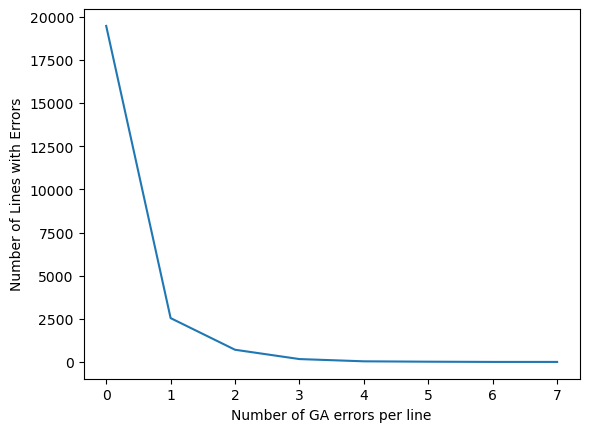

In [ ]:
counts = df_final['g_anno_error_cnt'].value_counts()
counts.plot()
plt.xlabel("Number of GA errors per line")
plt.ylabel("Number of Lines with Errors")
plt.show()

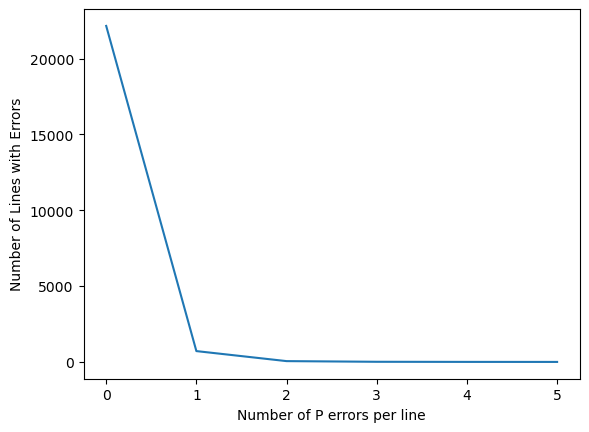

In [ ]:
counts = df_final['p_anno_error_cnt'].value_counts()
plt.xlabel("Number of P errors per line")
plt.ylabel("Number of Lines with Errors")
counts.plot()
plt.show()

extracting all the tag

In [ ]:
df_final['p_annotator_error_tag'] = df_final['p_annotator_list'].str.findall('<(.*?)>')
df_final['g_annotator_error_tag'] = df_final['g_annotator_list'].str.findall('<(.*?)>')
# df_final_v2['g_annotator_error_tag'] = df_final_v2['g_annotator_list'].str.extractall('<(.*?)>')

In [ ]:
df_final

,id,paragraph_id,is_duplicated,essay_new,p_annotator_list,g_annotator_list,p_anno_error_cnt,g_anno_error_cnt,p_annotator_error_tag,g_annotator_error_tag
0,146362,1,False,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,0,0,[],[]
0,146362,1,False,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,0,0,[],[]
0,146362,1,False,Ella ha asumido su papel de cantante que much...,Ella ha asumido su papel de cantante que much...,Ella ha asumido su papel de cantante que much...,0,0,[],[]
0,146362,1,False,Ella habla en contra del fanatismo y el odio ...,Ella habla en contra del fanatismo y el odio ...,Ella habla en contra del fanatismo y el odio ...,0,0,[],[]
0,146362,1,False,"Muchas niñas, especialmente las niñas que son...","Muchas niñas, especialmente las niñas que son...","Muchas niñas, especialmente las niñas que son...",0,3,[],"[ga:fm:det:an, ga:fm:gat:noun:an, ga:fm:adj:an]"
...,...,...,...,...,...,...,...,...,...,...
167,172450,1049,False,"Entonces, Hawaii es la casa a muchos frutas t...","Entonces, Hawaii es la casa a muchos frutas t...","Entonces, Hawaii es la casa a [muchos]{muchas...",0,2,[],"[ga:fm:det:inan, ga:fm:adj:an]"
167,172450,1049,False,Hawaii es un especial isla y tiene algunos vo...,Hawaii es un especial isla y tiene algunos vo...,Hawaii es [un]{una}<ga:fm:det:inan> especial ...,0,1,[],[ga:fm:det:inan]
167,172450,1049,False,"EN la isla largo, tu veas (lava) ir en la oce...","EN la isla largo, tu veas (lava) ir en la oce...","EN la isla [largo]{larga}<ga:fm:adj:inan>, tu...",0,1,[],[ga:fm:adj:inan]
167,172450,1049,False,\n\nYo quiero ir a Hwaii con mi novio prque e...,\n\nYo quiero ir a Hwaii con mi novio prque e...,\n\nYo quiero ir a Hwaii con mi novio prque e...,0,0,[],[]


In [ ]:
df_p_tags_exploded = df_final.explode('p_annotator_error_tag')

<AxesSubplot: xlabel='P error annotation', ylabel='Occurences'>

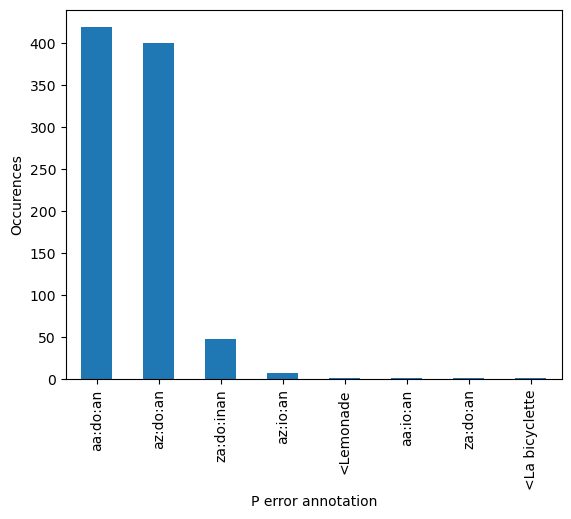

In [ ]:
counts = df_p_tags_exploded.p_annotator_error_tag.value_counts()
plt.ylabel("Occurences")
plt.xlabel("P error annotation")
counts.plot.bar()

In [ ]:
df_p_tags_exploded[(df_p_tags_exploded.p_annotator_error_tag == '<Lemonade') | (df_p_tags_exploded.p_annotator_error_tag == '<La bicyclette')]

,id,paragraph_id,is_duplicated,essay_new,p_annotator_list,g_annotator_list,p_anno_error_cnt,g_anno_error_cnt,p_annotator_error_tag,g_annotator_error_tag
64,127886,44,False,\n\nEl álbum más reciente <<Lemonade>> es sob...,\n\nEl álbum más reciente <<Lemonade>> es sob...,\n\nEl álbum más reciente <<Lemonade>> es sob...,0,0,<Lemonade,[<Lemonade]
57,127886,589,False,Por las mañanas iríamos al cafe se llama <<La...,Por las mañanas iríamos al cafe se llama <<La...,Por las mañanas iríamos al cafe se llama <<La...,0,0,<La bicyclette,[<La bicyclette]


In [ ]:
df_g_tags_exploded = df_final.explode('g_annotator_error_tag')
# counts = df_g_tags_exploded.g_annotator_error_tag.value_counts()
# counts.plot.bar()


<AxesSubplot: xlabel='G error (first tag)', ylabel='Occurences'>

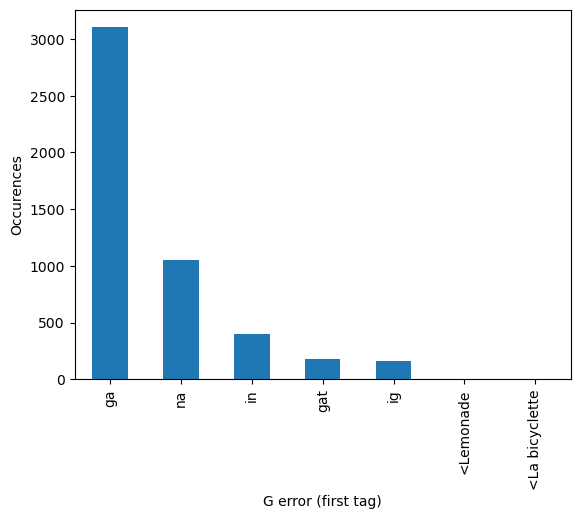

In [ ]:
g_split_tags = df_g_tags_exploded.g_annotator_error_tag.str.split(":", expand=True)
plt.ylabel("Occurences")
plt.xlabel("G error (first tag)")
g_split_tags[0].value_counts().plot.bar()

<AxesSubplot: xlabel='G error (first two tags)', ylabel='Occurences'>

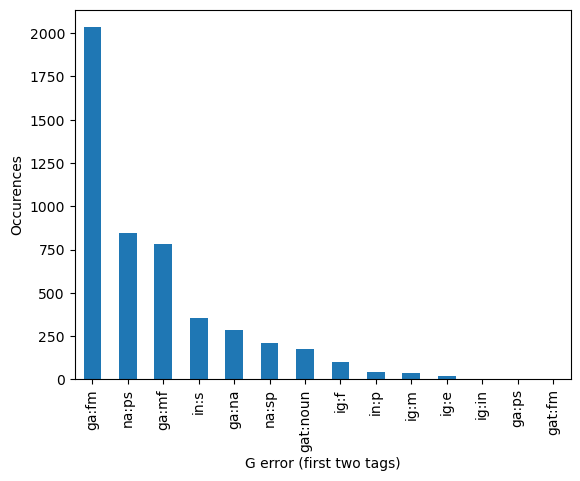

In [ ]:
g_split_tags['first_two'] = g_split_tags[0] + ":" + g_split_tags[1]
plt.ylabel("Occurences")
plt.xlabel("G error (first two tags)")
g_split_tags['first_two'].value_counts().plot.bar()


### Sentence length

In [ ]:
senten